<a href="https://colab.research.google.com/github/Phatdat01/recommendation/blob/main/restaurantRecommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mlflow
!pip install gdown
!gdown 1A-Uwe762UZ8ufw1KpkeuFPYF7znvnVy4
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 17.0 MB 121 kB/s 
     |████████████████████████████████| 147 kB 66.7 MB/s 
     |████████████████████████████████| 209 kB 71.5 MB/s 
     |████████████████████████████████| 79 kB 3.9 MB/s 
     |████████████████████████████████| 182 kB 74.9 MB/s 
     |████████████████████████████████| 77 kB 8.7 MB/s 
     |████████████████████████████████| 78 kB 8.7 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 
     |████████████████████████████████| 55 kB 3.7 MB/s 
     |████████████████████████████████| 140 kB 48.3 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
  Created wheel for databricks-cli: filename=databricks_cli-0.17.3-py3-none-any.whl size=139102 sha256=000b4e10d1acfcd226875308a14f1211521a4863b8e293b987a7aabb13005d1d
  Stored in directory: /root/.cache/pip/wheels/3f/73/87/c1e4b2145eb6049bb6c9aaf7ea1e38302b77ca219b6fef5d5c


In [ ]:
!pip install --upgrade --no-cache-dir gdown
!python -m gdown.cli "https://drive.google.com/uc?id=1A-Uwe762UZ8ufw1KpkeuFPYF7znvnVy4&confirm=t"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
Downloading...
From: https://drive.google.com/uc?id=1A-Uwe762UZ8ufw1KpkeuFPYF7znvnVy4&confirm=t
To: /content/yelp_dataset.tar
100% 4.34G/4.34G [00:57<00:00, 75.0MB/s]


In [ ]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
import numpy as np
from datetime import datetime
import tarfile
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
!mkdir yelp_dataset
%cd /content/yelp_dataset
my_tar = tarfile.open('/content/yelp_dataset.tar')
my_tar.extract('yelp_academic_dataset_review.json',".")
my_tar.close()
!rm /content/yelp_dataset.tar

/content/yelp_dataset


In [ ]:
%cd /content/yelp_dataset
!ls

/content/yelp_dataset
yelp_academic_dataset_review.json


In [ ]:
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '5000')\
        .getOrCreate()

In [ ]:
df = spark.read.json("/content/yelp_dataset/yelp_academic_dataset_review.json")
df.printSchema()
df.show(5)

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPp

In [ ]:
ratings=df.select("user_id","business_id","stars","date","cool","funny","useful")

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id
##Because ALS in spark require users or items is  in int type, we must process it
userRatings=ratings.groupBy("user_id").count().withColumn("userid", monotonically_increasing_id().cast(IntegerType()))
userRatings.show(5)

+--------------------+-----+------+
|             user_id|count|userid|
+--------------------+-----+------+
|3M1_pyDSgMP6sRMz5...|    2|     0|
|3rSKIFAWcJ-0jkRJc...|    1|     1|
|dMrmnopCJ0xxEuG7W...|   67|     2|
|kbx5teHlHE1D0WMtp...|    3|     3|
|4P_GCHFMV0mF2SqEW...|    1|     4|
+--------------------+-----+------+
only showing top 5 rows



In [ ]:
buiRatings=ratings.groupBy("business_id").count().withColumn("businessid", monotonically_increasing_id().cast(IntegerType()))

newratings=ratings.join(userRatings, ratings.user_id ==  userRatings.user_id,"inner")
newratings=newratings.join(buiRatings, newratings.business_id ==  buiRatings.business_id,"inner")
newratings=newratings.select("userid","businessid","stars","date","cool","funny","useful")


In [ ]:
print(newratings)
newratings.show(5)

DataFrame[userid: int, businessid: int, stars: double, date: string, cool: bigint, funny: bigint, useful: bigint]
+------+----------+-----+-------------------+----+-----+------+
|userid|businessid|stars|               date|cool|funny|useful|
+------+----------+-----+-------------------+----+-----+------+
| 36790|      5774|  5.0|2020-02-20 00:50:49|   0|    0|     1|
| 36015|      5774|  4.0|2021-11-28 16:40:02|   0|    0|     0|
| 64986|      5774|  5.0|2021-10-17 02:02:58|   0|    0|     0|
| 23627|      5774|  5.0|2020-03-18 01:34:18|   0|    0|     2|
| 61265|      5774|  5.0|2020-09-05 20:09:03|   0|    0|     0|
+------+----------+-----+-------------------+----+-----+------+
only showing top 5 rows



In [ ]:
newratings=newratings.withColumn("stars",col("stars").cast(IntegerType()))
newratings=newratings.withColumn("date",to_timestamp("date"))
newratings=newratings.withColumn("cool",col("cool").cast(IntegerType()))
newratings=newratings.withColumn("funny",col("funny").cast(IntegerType()))
newratings=newratings.withColumn("useful",col("useful").cast(IntegerType()))

print(newratings)
newratings.show(5)

DataFrame[userid: int, businessid: int, stars: int, date: timestamp, cool: int, funny: int, useful: int]
+------+----------+-----+-------------------+----+-----+------+
|userid|businessid|stars|               date|cool|funny|useful|
+------+----------+-----+-------------------+----+-----+------+
| 36790|      5774|    5|2020-02-20 00:50:49|   0|    0|     1|
| 36015|      5774|    4|2021-11-28 16:40:02|   0|    0|     0|
| 64986|      5774|    5|2021-10-17 02:02:58|   0|    0|     0|
| 23627|      5774|    5|2020-03-18 01:34:18|   0|    0|     2|
| 61265|      5774|    5|2020-09-05 20:09:03|   0|    0|     0|
+------+----------+-----+-------------------+----+-----+------+
only showing top 5 rows



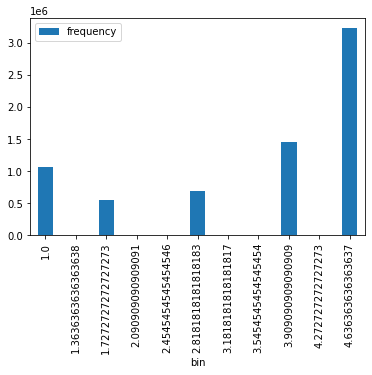

In [ ]:
gre_histogram = newratings.select('stars').rdd.flatMap(lambda x: x).histogram(11)

pd.DataFrame(
    list(zip(*gre_histogram)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

In [ ]:
df1 = newratings.withColumn('year',year(newratings.date))
df1 = newratings.withColumn('year',year(newratings.date))
display(df1)

DataFrame[userid: int, businessid: int, stars: int, date: timestamp, cool: int, funny: int, useful: int, year: int]

In [ ]:
df2=df1.groupBy("businessid").agg(avg("stars").alias("meanstars"),count('userid').alias('numUser'))
display(df2)

DataFrame[businessid: int, meanstars: double, numUser: bigint]

## Because there is some problem if you collect by date  while the items don't have any rating, so it can be difficult to predict

In [ ]:
numtest=int(newratings.count()*0.4)
ortherDate=newratings.orderBy(col("date").desc())
testing=ortherDate.limit(int(numtest))
(_, testing) = testing.randomSplit([0.5, 0.5])
training = newratings.subtract(testing)

print(testing.count())
testing.show(5)
print(training.count())

1397386
+------+----------+-----+-------------------+----+-----+------+
|userid|businessid|stars|               date|cool|funny|useful|
+------+----------+-----+-------------------+----+-----+------+
|     0|       914|    5|2018-07-26 09:15:30|   0|    0|     0|
|     0|      2751|    5|2020-06-10 13:50:11|   1|    0|     0|
|     0|      2967|    5|2021-10-19 13:24:25|   1|    1|     2|
|     0|      4435|    5|2018-10-26 20:44:12|   1|    0|     2|
|     0|      5983|    5|2018-10-26 23:30:31|   2|    0|     3|
+------+----------+-----+-------------------+----+-----+------+
only showing top 5 rows

5592879


In [ ]:
from multiprocessing.pool import ThreadPool as Pool
from datetime import datetime

def worker(i):
  start=datetime.now()
  print(f"processing time: {datetime.now()}")
  als= ALS(rank=5, maxIter=5, regParam=0.15, userCol="businessid", itemCol="userid", ratingCol="stars", nonnegative=True,implicitPrefs = False,coldStartStrategy="drop")
  model = als.fit(training)
  print(f"processing time: {datetime.now()}")
  predictions=model.transform(testing)
  print(f"processing time: {datetime.now()}")
  evaluator = RegressionEvaluator(metricName="rmse", labelCol="stars", predictionCol="prediction")
  rmse = evaluator.evaluate(predictions)
  print(f"time {i} RMSE={rmse}")
  end=datetime.now()
  print(f"processing time: {end-start}")
    
# pool = Pool(2)
item=5
worker(item)

# Normal

In [ ]:
from multiprocessing.pool import ThreadPool as Pool
from datetime import datetime

def worker(i):
  start=datetime.now()
  print(f"processing time: {datetime.now()}")
  als= ALS(rank=5, maxIter=5, regParam=0.15, userCol="userid", itemCol="businessid", ratingCol="stars", nonnegative=True,implicitPrefs = False,coldStartStrategy="drop")
  model = als.fit(training)
  print(f"processing time: {datetime.now()}")
  predictions=model.transform(testing)
  print(f"processing time: {datetime.now()}")
  evaluator = RegressionEvaluator(metricName="rmse", labelCol="stars", predictionCol="prediction")
  rmse = evaluator.evaluate(predictions)
  print(f"time {i} RMSE={rmse}")
  end=datetime.now()
  print(f"processing time: {end-start}")
    
# pool = Pool(2)
item=5
worker(item)

# stratified sampling

In [ ]:
rat1=newratings.where(col("stars")==1)
rat2=newratings.where(col("stars")==2)
rat3=newratings.where(col("stars")==3)
rat4=newratings.where(col("stars")==4)
rat5=newratings.where(col("stars")==5)

In [ ]:
def trainTestSPlit(newratings):
    numtest=int(newratings.count()*0.4)
    ortherDate=newratings.orderBy(col("date").desc())
    testing=ortherDate.limit(int(numtest))
    (_, testing) = testing.randomSplit([0.5, 0.5])
    training = newratings.subtract(testing)
    return training,testing

In [ ]:
train1,test1=trainTestSPlit(rat1)
train2,test2=trainTestSPlit(rat2)
train3,test3=trainTestSPlit(rat3)
train4,test4=trainTestSPlit(rat4)
train5,test5=trainTestSPlit(rat5)

In [ ]:
mertrain=train1.union(train2).union(train3).union(train4).union(train5)
mertest=test1.union(test2).union(test3).union(test4).union(test5)

In [ ]:
from multiprocessing.pool import ThreadPool as Pool
from datetime import datetime

predictions=None

def work(i,train,test):
  start=datetime.now()
  als= ALS(rank=i, maxIter=5, regParam=0.15, userCol="businessid", itemCol="userid", ratingCol="stars", nonnegative=True,implicitPrefs = False,coldStartStrategy="drop")
  model = als.fit(train)
  ski=datetime.now()-start
  print(f"Time fit model: {ski}")
  predictions=model.transform(test)
  print(f"Time predict: {datetime.now()-ski}")
  evaluator = RegressionEvaluator(metricName="rmse", labelCol="stars", predictionCol="prediction")
  rmse = evaluator.evaluate(predictions)
  print(f"time {i} RMSE={rmse}")
  end=datetime.now()
  print(f"processing time: {end-start}")
  return predictions

i=0   
for item in range(3,15):
  prediction=work(item,mertrain,mertest)
  if i==1:
    predictions=prediction
  i+=1


# Multi processing

In [ ]:
from multiprocessing.pool import ThreadPool as Pool

def worker(i,flag):
    als= ALS(rank=5, maxIter=5, regParam=0.15, userCol="userid", itemCol="businessid", ratingCol="stars", nonnegative=True,implicitPrefs = False,coldStartStrategy="drop")
    model = als.fit(training)
    predictions=model.transform(testing)
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="stars", predictionCol="prediction")
    rmse = evaluator.evaluate(predictions)
    print(f"time {i} with flag {flag}: RMSE={rmse}")
    
pool = Pool(10)
for item in range(5,15):
  for flag in [True,False]:
    pool.apply_async(worker, (item,flag))
    
pool.close()
pool.join()

# Cross validation

In [ ]:
# Cross validation
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel

als= ALS(rank=5, maxIter=5, regParam=0.15, userCol="userid", itemCol="businessid", ratingCol="stars", nonnegative=True,implicitPrefs = False,coldStartStrategy="drop")
print("Load complete als model")
print(als)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="stars", predictionCol="prediction")
params = ParamGridBuilder().addGrid(als.regParam,[.01, .05, .1, .15]).build()
print(params)
print("That's params")
cv = CrossValidator(estimator=als, estimatorParamMaps=params, evaluator=evaluator, parallelism=4, numFolds= 5)
print(f"Load cross validation {cv}")
best_model = cv.fit(newratings)
model = best_model.bestModel
print(model)

Load complete als model
ALS_6581ec885334
[{Param(parent='ALS_6581ec885334', name='regParam', doc='regularization parameter (>= 0).'): 0.01}, {Param(parent='ALS_6581ec885334', name='regParam', doc='regularization parameter (>= 0).'): 0.05}, {Param(parent='ALS_6581ec885334', name='regParam', doc='regularization parameter (>= 0).'): 0.1}, {Param(parent='ALS_6581ec885334', name='regParam', doc='regularization parameter (>= 0).'): 0.15}]
That's params
Load cross validation CrossValidator_37a77c99dc94


In [ ]:
predictions=model.transform(testing)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="stars", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"RMSE={rmse}")

# Recommendation Show

In [ ]:
rcm = model.recommendForAllUsers(10)
rcm.show(10)

In [ ]:
recommendations = rcm.withColumn("rec_exp", explode("recommendations"))\
    .select('userId', col("newratings.businessid"), col("newratings.stars"))
recommendations.limit(10).show()

# USE LAYER

## Compile Linear

In [ ]:
 import io
from pyspark.sql.funtions import flatten
from pyspark.ml.linalg import DenseVector


a=newratings.count()
users=newratings.collect(col("userid"))
items=newratings.collect(col("businessid"))
